In [63]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from astroML import stats as astroMLstats
from sklearn.mixture import GaussianMixture
from tqdm import tqdm
from scipy import integrate, optimize
from scipy.stats import norm
from scipy.stats import uniform
from astroML.plotting import hist
from astroML.plotting.mcmc import convert_to_stdev
from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=8, usetex=True)
import warnings; warnings.simplefilter('ignore')
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.cluster import estimate_bandwidth
from sklearn.neighbors import KernelDensity
from sklearn import preprocessing

In [2]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [3]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [26]:
T90=np.array(data[6],dtype=float)
fluence = np.array(data[9],dtype=float)
redshift = np.array(data[11],dtype=float)
condition = (T90 > 0) & (fluence > 0)
X = np.vstack((np.log10(T90[condition]), np.log10(fluence[condition]))).T
print(X)

[[ 1.74067843 -5.77293641]
 [ 1.32731806 -5.34281981]
 [ 0.85521619 -5.44272143]
 ...
 [ 0.49637605 -7.60453382]
 [ 2.31926433 -6.78225293]
 [ 0.71466499 -5.58410892]]


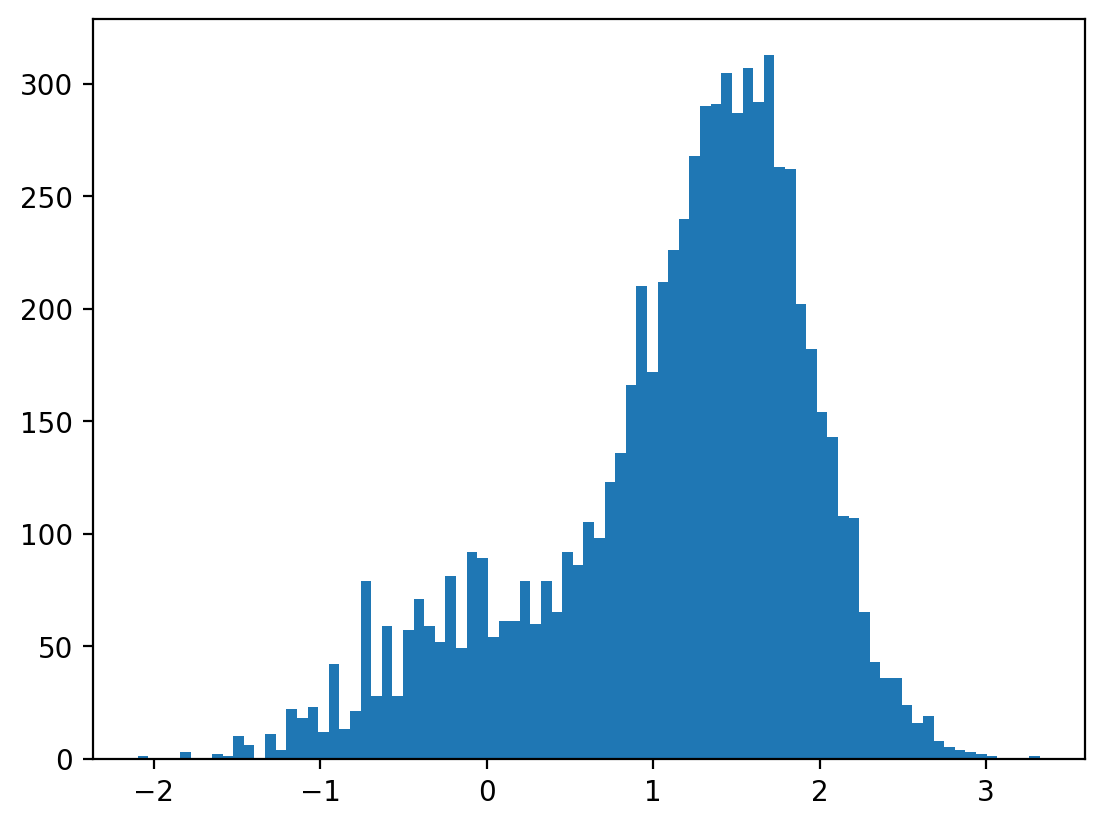

In [59]:
plt.hist(X[:,0], bins = int(np.sqrt(len(X))));

Let's fit the pdf with a KDE, estimating the bandwidth with cross validation

In [66]:
#Execute this cell to determine the bandwidth
bwrange = np.linspace(0.01,1.0, 40) # Test 30 bandwidths from 0.1 to 1.0
K = 2 # Do 2-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K) # Try each bandwidth with K-folds
grid.fit(X[:, 0].reshape(-1, 1)) #Fit the histogram data that we started the lecture with.
h_opt = grid.best_params_['bandwidth']
print(h_opt)

0.13692307692307693


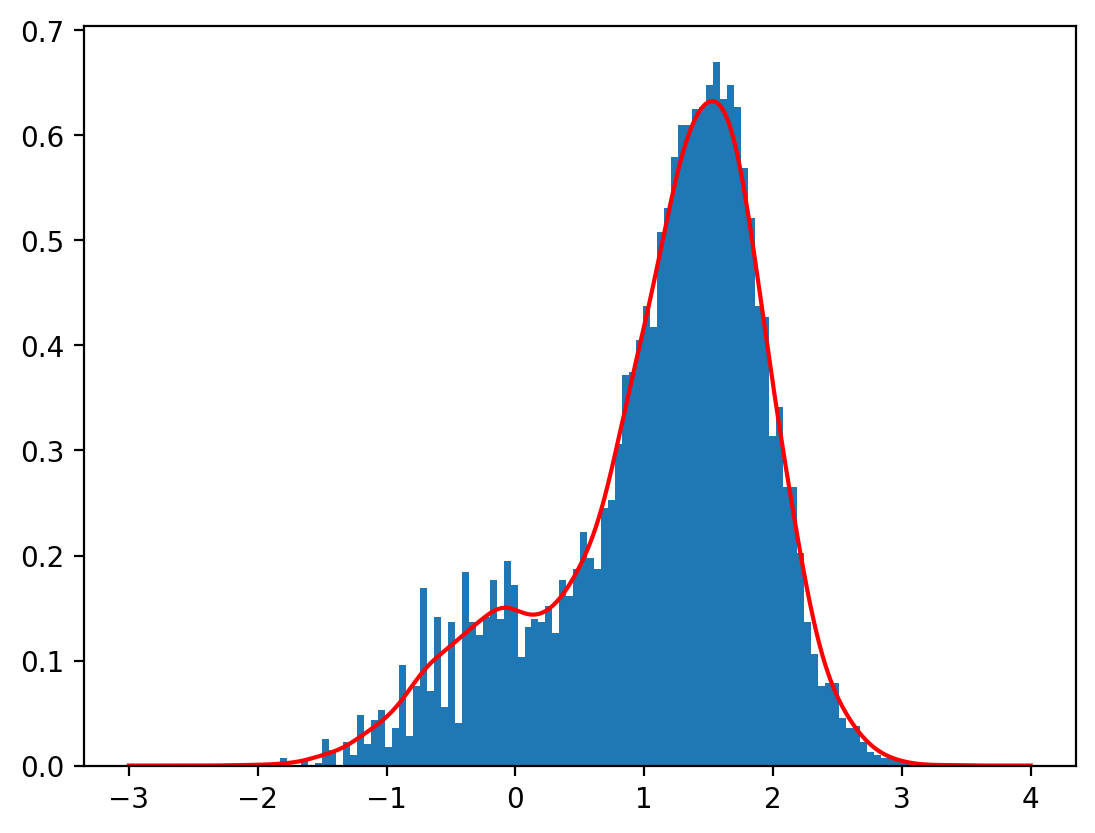

In [71]:
def kde_sklearn(data, bandwidth = 1.0):
    kde_skl = KernelDensity(bandwidth = bandwidth)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis]) # sklearn returns log(density)
    return np.exp(log_pdf)

x_grid = np.linspace(-3,4,len(X[:, 0]))
pdf = kde_sklearn(X[:, 0],bandwidth=h_opt)
plt.hist(X[:, 0], bins = 100, density = True)
plt.plot(x_grid,pdf, color = 'red');

# Clustering 1D

## GMM

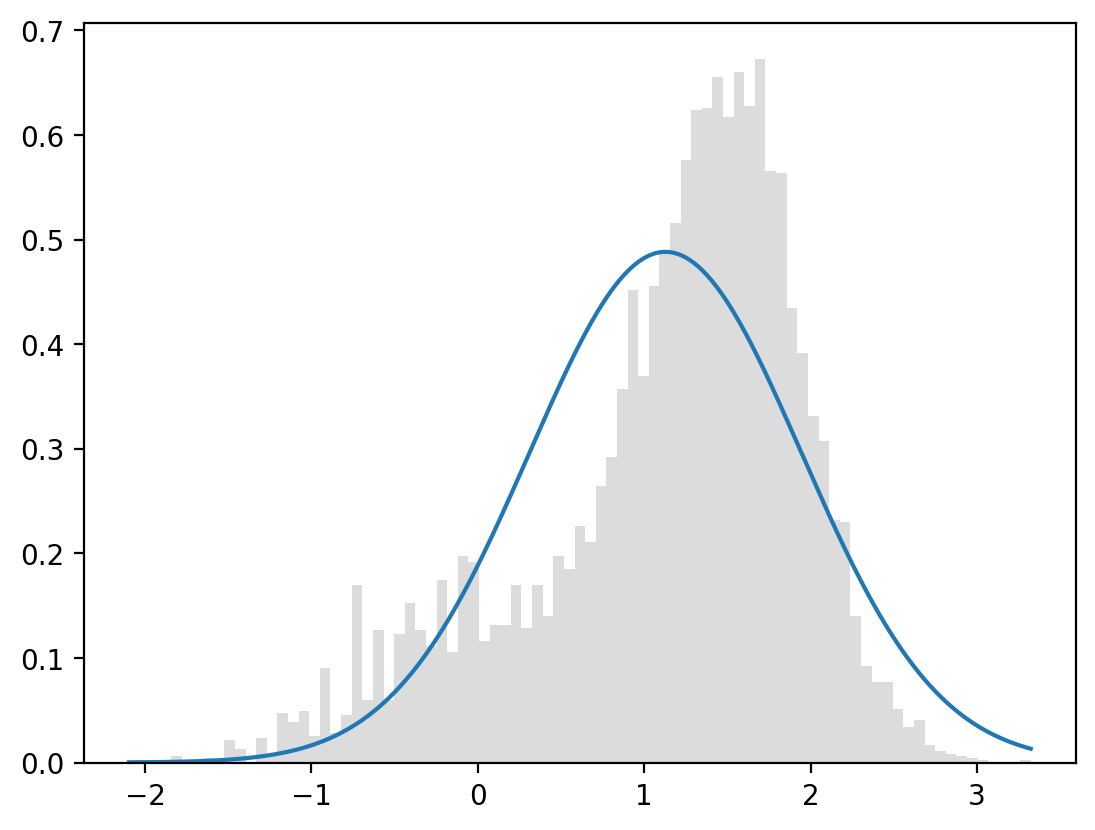

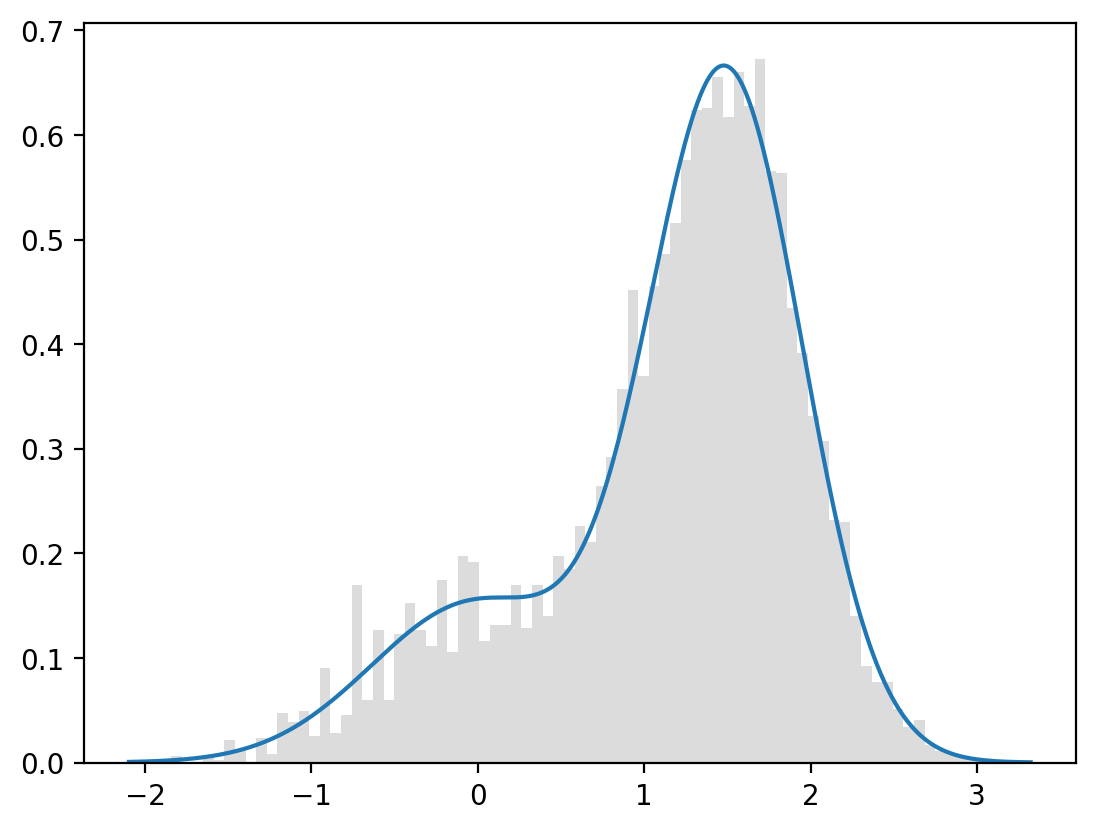

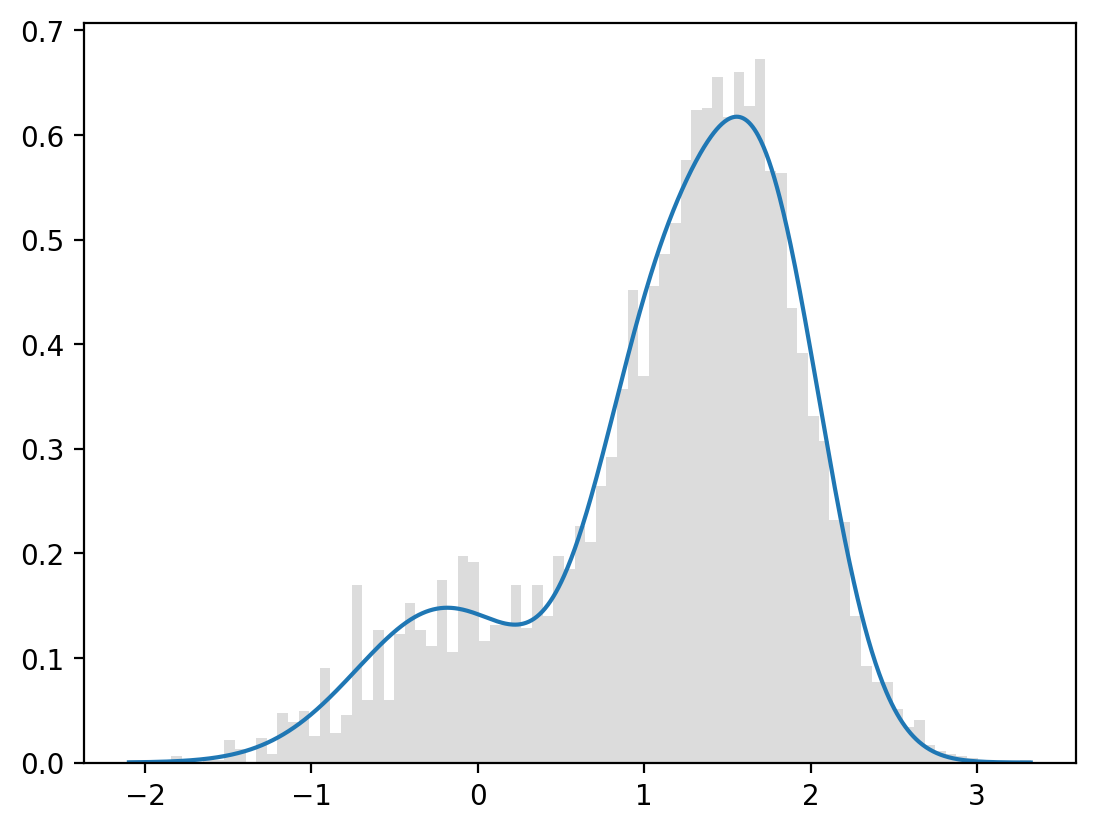

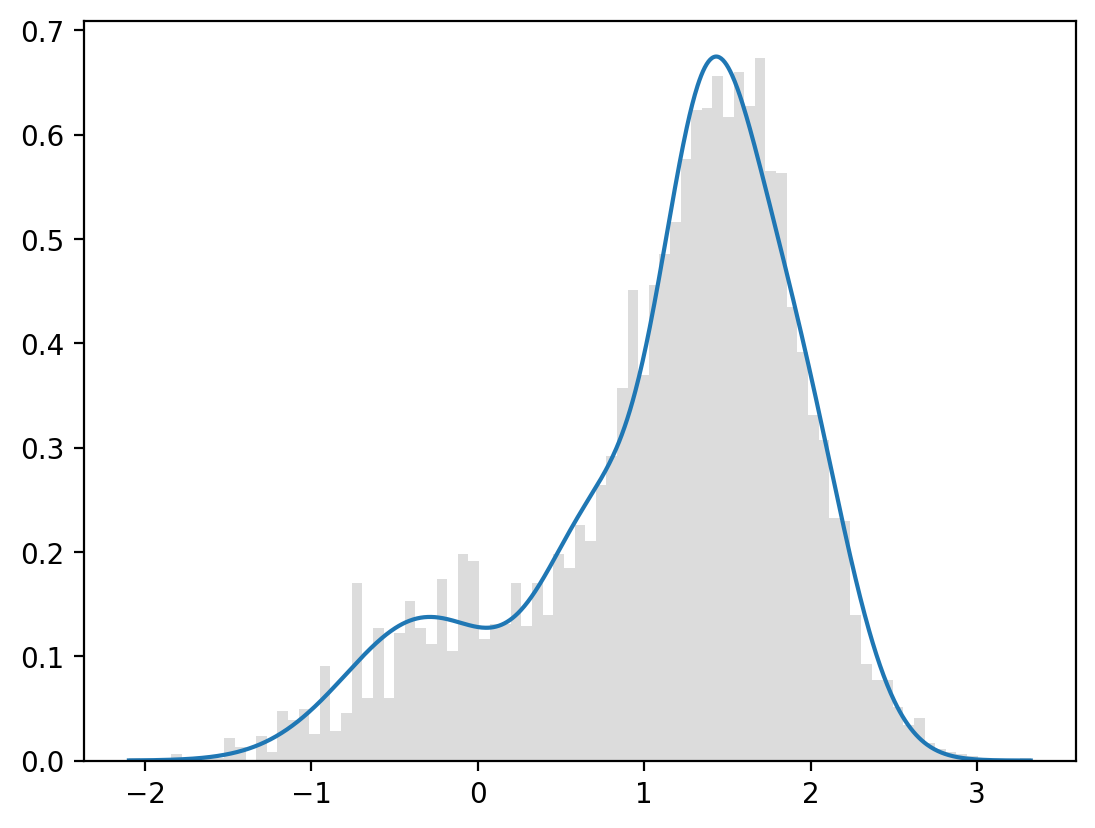

In [28]:
NvsAIC = np.zeros(shape = (4,2))
NvsBIC = np.zeros(shape = (4,2))

for n_comps in range(1,5):
    
    plt.hist(X[:,0], bins = int(np.sqrt(len(X))), density = True, color = 'gainsboro')
    
    x_fit = np.linspace(min(X[:,0]),max(X[:,0]),1000)
    
    gm = GaussianMixture(n_components = n_comps, covariance_type='diag', random_state=0).fit(X[:,0].reshape(-1, 1))
    
    log_L = gm.score_samples(x_fit.reshape(-1, 1)) #gives the logL of the sample
    pdf = np.exp(log_L)
    
    plt.plot(x_fit, pdf)
    
    NvsAIC[n_comps - 1] = [n_comps, gm.aic(X[:,0].reshape(-1, 1))]
    NvsBIC[n_comps - 1] = [n_comps, gm.bic(X[:,0].reshape(-1, 1))]
    
    plt.show()

AIC best number of components = 2.0
BIC best number of components = 2.0


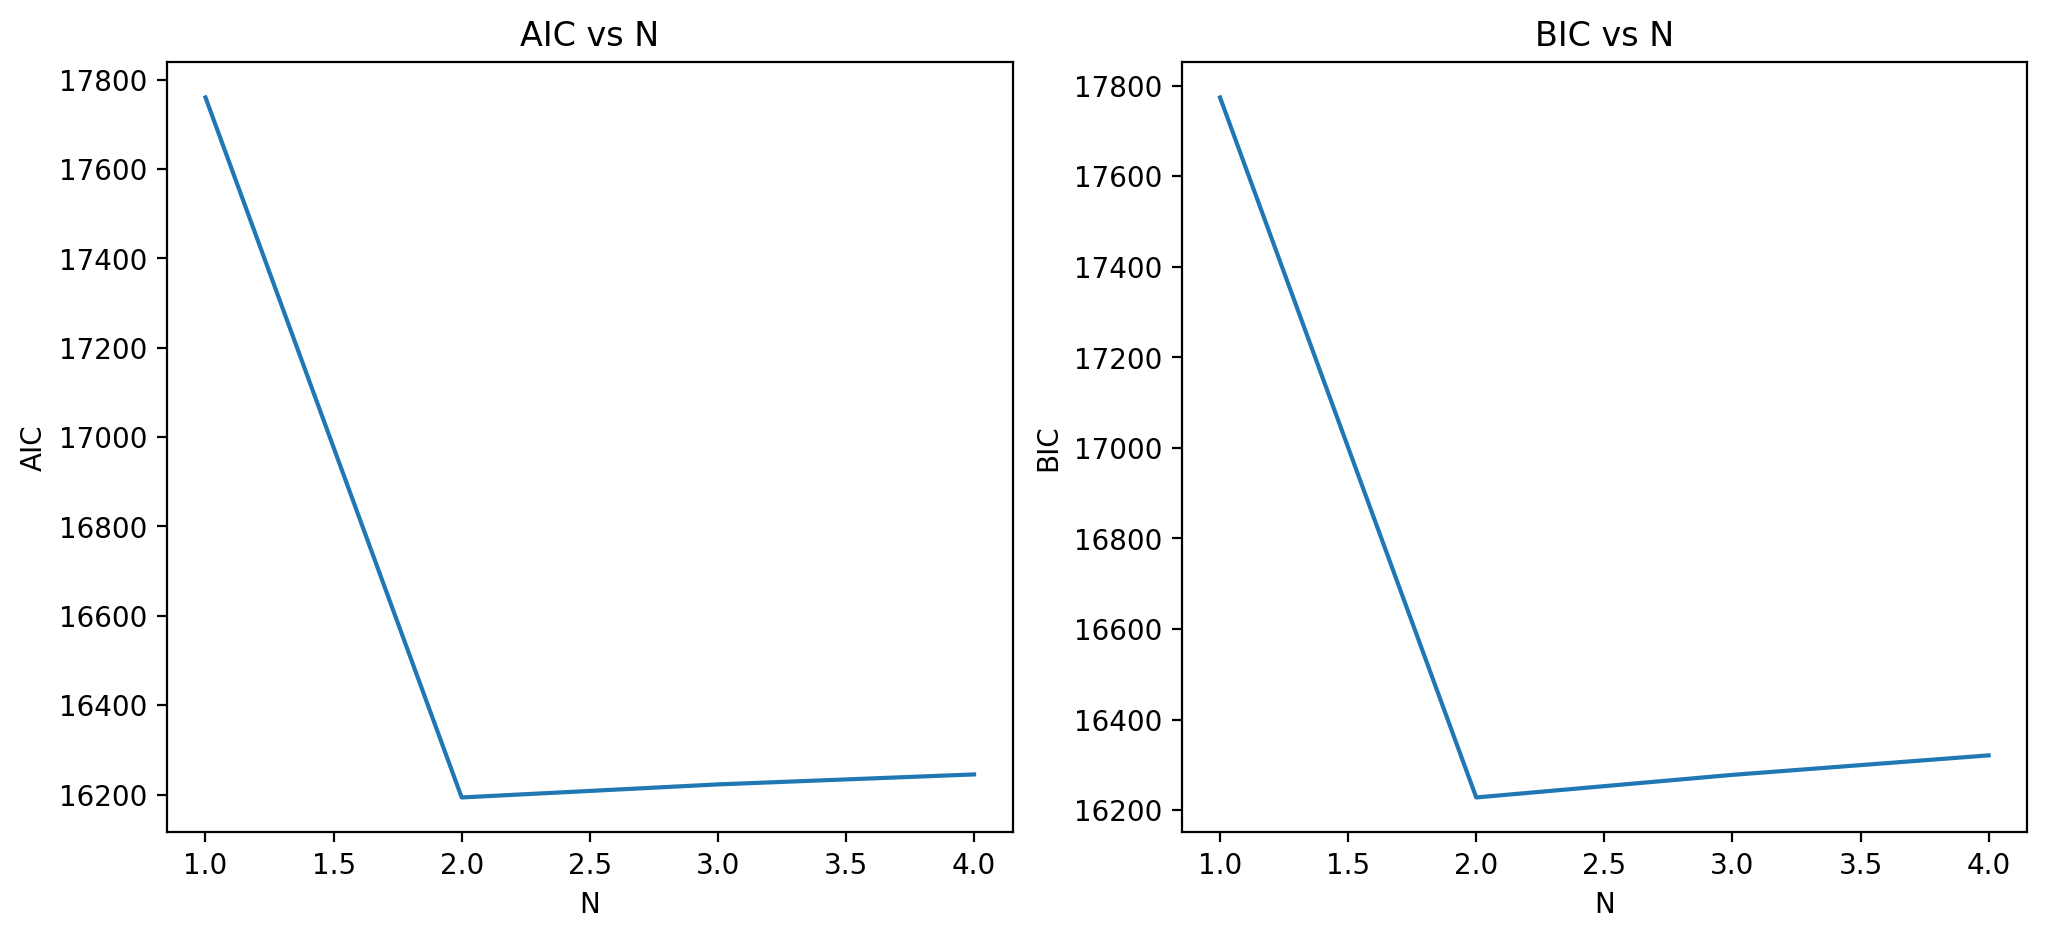

In [29]:
print('AIC best number of components = ' + str(NvsAIC[:,0][np.argmin(NvsAIC[:,1])]))
print('BIC best number of components = ' + str(NvsBIC[:,0][np.argmin(NvsBIC[:,1])]))

fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(121)
ax.plot(NvsAIC[:,0], NvsAIC[:,1])
ax.set_xlabel('N')
ax.set_ylabel('AIC')
ax.set_title('AIC vs N')

ax = fig.add_subplot(122)
ax.plot(NvsBIC[:,0], NvsBIC[:,1])
ax.set_xlabel('N')
ax.set_ylabel('BIC')
ax.set_title('BIC vs N');

Text(0.5, 0, 'T90')

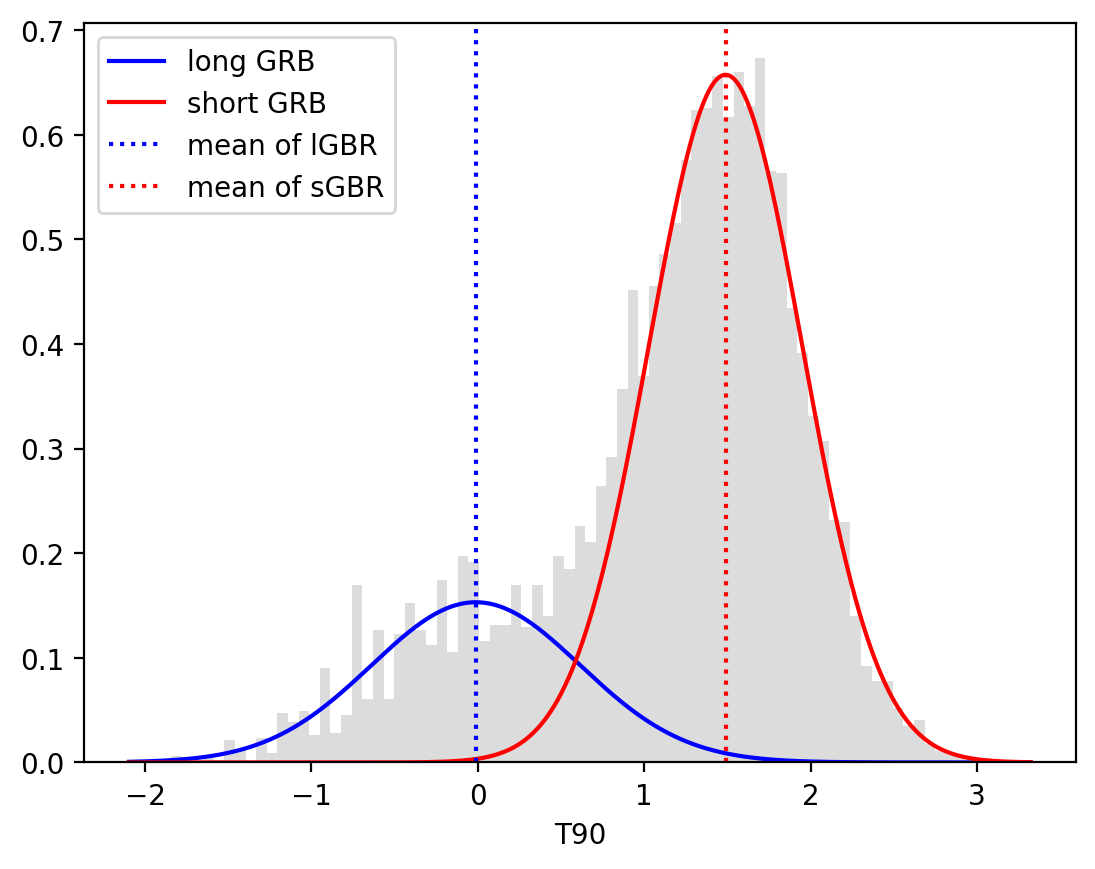

In [30]:
gm_good = GaussianMixture(n_components = 2, covariance_type='diag', random_state=0).fit(X[:,0].reshape(-1, 1))
plt.hist(X[:,0], bins = int(np.sqrt(len(X))), density = True, color = 'gainsboro')
log_L = gm_good.score_samples(x_fit.reshape(-1, 1))
pdf = np.exp(log_L)

resp = gm_good.predict_proba(x_fit.reshape(-1, 1)) #gives the probability of the components for each sample
means = gm_good.means_
component = resp * pdf[:, np.newaxis]

plt.plot(x_fit, component[:,0], c='blue', label = 'long GRB')
plt.plot(x_fit, component[:,1], c='red', label = 'short GRB')   
plt.axvline(means[0], c = 'blue',ls = 'dotted', label = 'mean of lGBR' )
plt.axvline(means[1], c = 'r',ls = 'dotted', label = 'mean of sGBR' )

#plt.plot(x_fit, pdf, '--k')
plt.legend()

plt.xlabel("T90")

## Kmeans

In [31]:
clf = KMeans(n_clusters=2, n_init='auto')
clf.fit(X[:,0].reshape(-1, 1))
centers = clf.cluster_centers_
labels = clf.predict(X[:,0].reshape(-1, 1))
treshold = np.mean( [max(X[labels==0, 0]), min(X[labels==1, 0])] )

In [32]:
if centers[0]>centers[1]:
    centers=centers[::-1] # Reverse array
    labels = np.array(~np.array(labels,dtype='bool'),dtype='int') # Swap 0 <--> 1

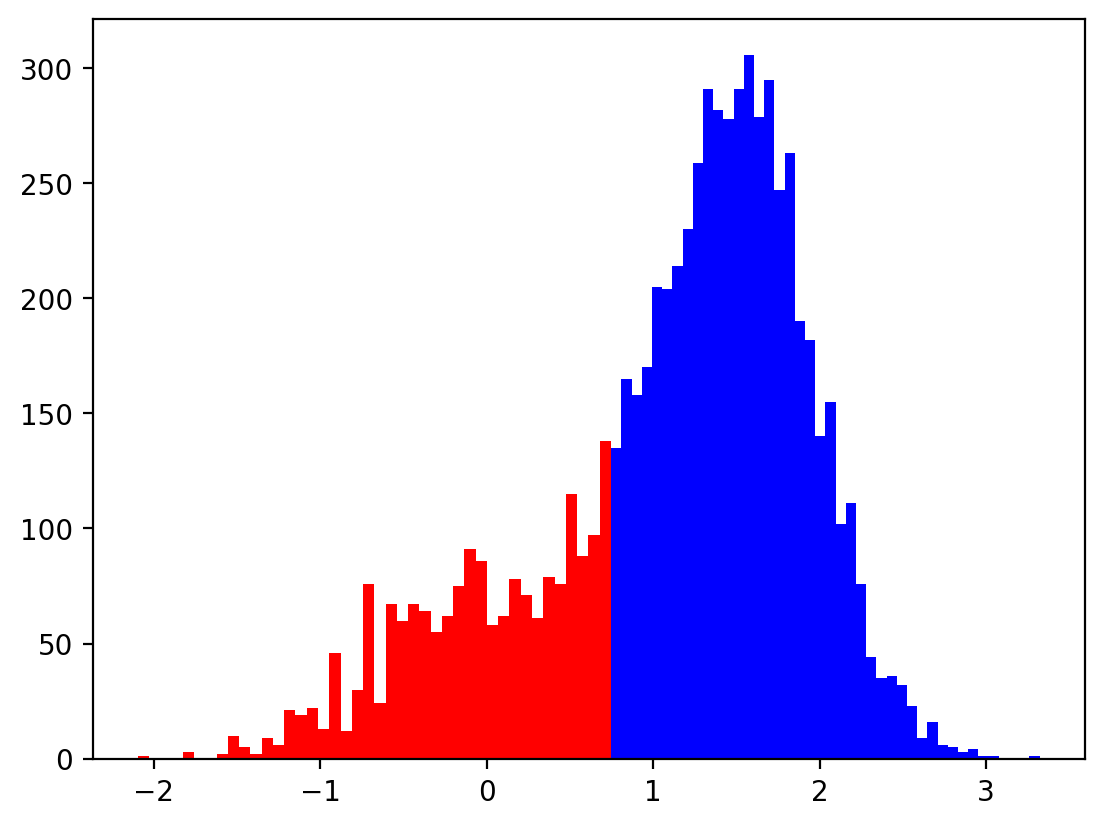

In [33]:
plt.hist(X[labels==0, 0], bins = int(np.sqrt(len(X))/2), density = False, color = 'red');
plt.hist(X[labels==1, 0], bins = int(np.sqrt(len(X))/2), density = False, color = 'blue');

Let's compare the centers obtained with the two methods

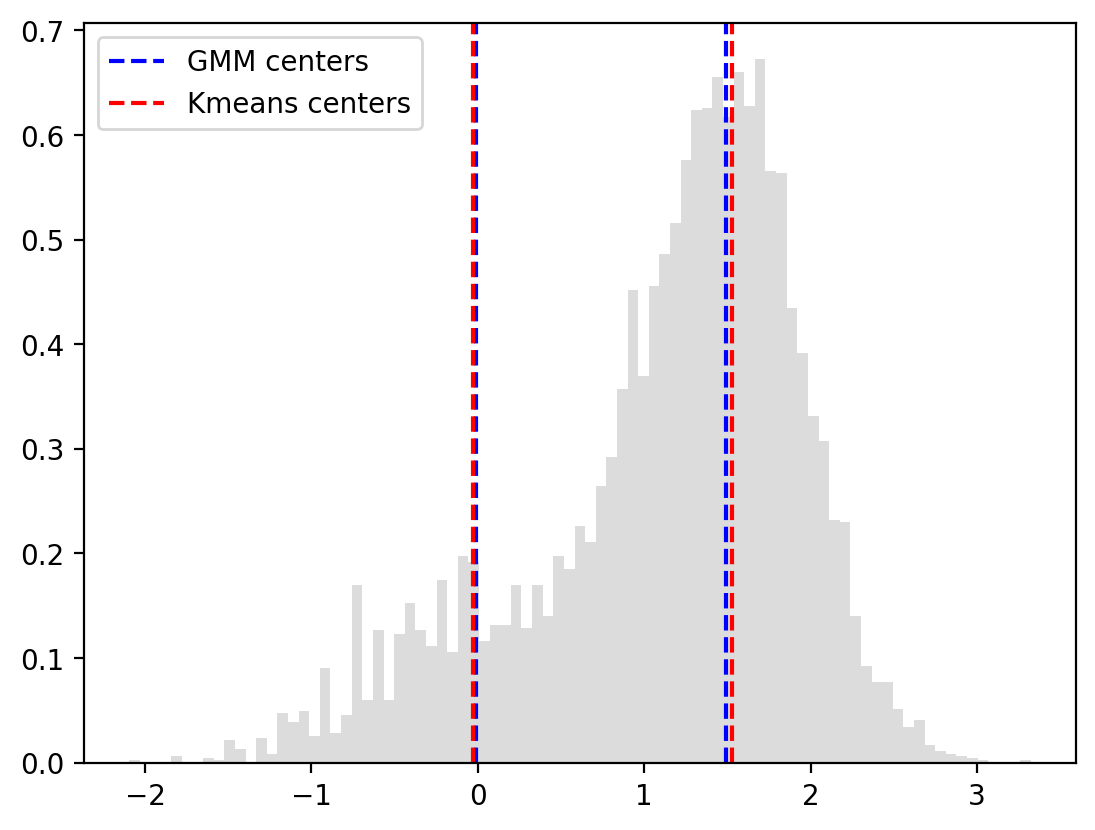

In [34]:
plt.hist(X[:,0], bins = int(np.sqrt(len(X))), density = True, color = 'gainsboro')
plt.axvline(means[0], c = 'blue',ls = '--', label = 'GMM centers' )
plt.axvline(means[1], c = 'blue',ls = '--')
plt.axvline(centers[0], c = 'red',ls = '--', label = 'Kmeans centers' )
plt.axvline(centers[1], c = 'red',ls = '--')
plt.legend()

## Confusion matrix

In [35]:
resp = gm_good.predict_proba(X[:,0].reshape(-1, 1))

if means[0]>means[1]:
    means=means[::-1]
    resp= resp[:,::-1]
    
GMM_result = np.array(resp[:,0]<resp[:,1],dtype='int')

confusion_matrix(GMM_result,labels)

array([[1583,    0],
       [ 268, 5444]], dtype=int64)

Some long GRBs are confused with the short ones.

# Clustering 2D

## Kmeans

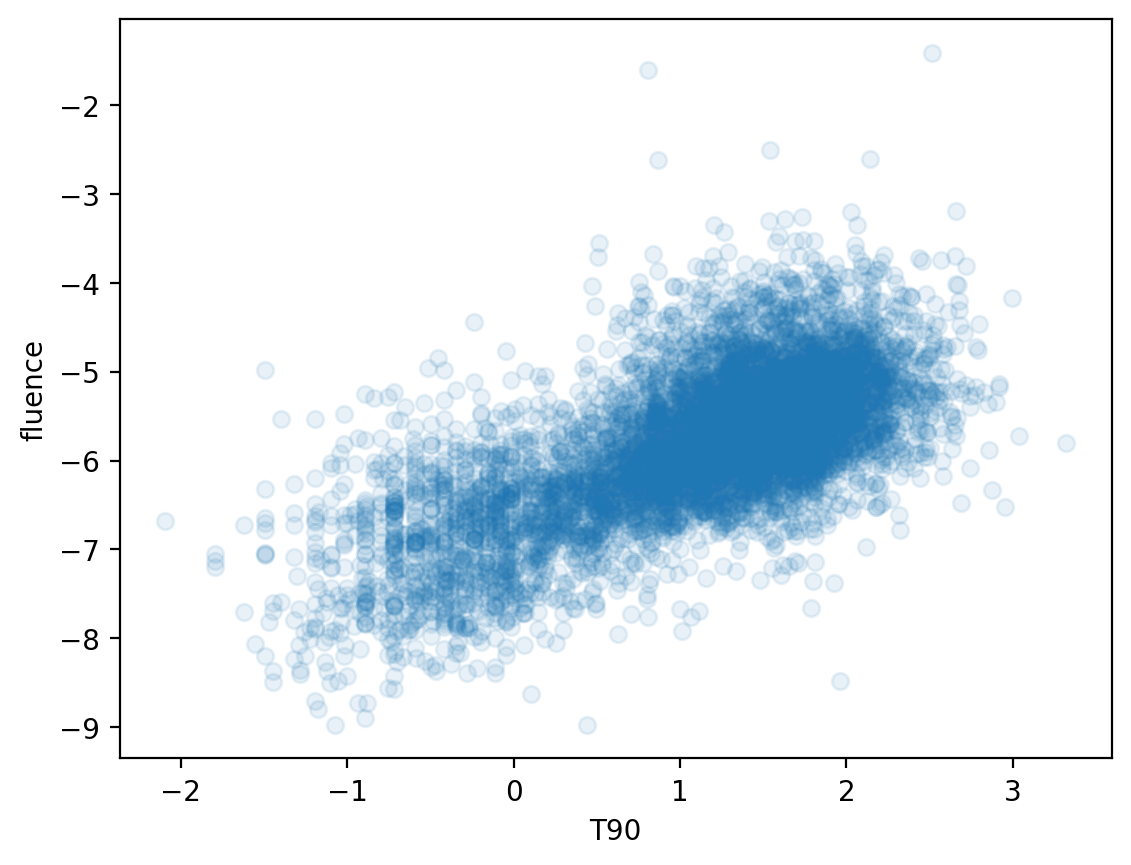

In [36]:
plt.xlabel("T90")
plt.ylabel("fluence")
plt.scatter(X[:,0], X[:,1], alpha = 0.1);

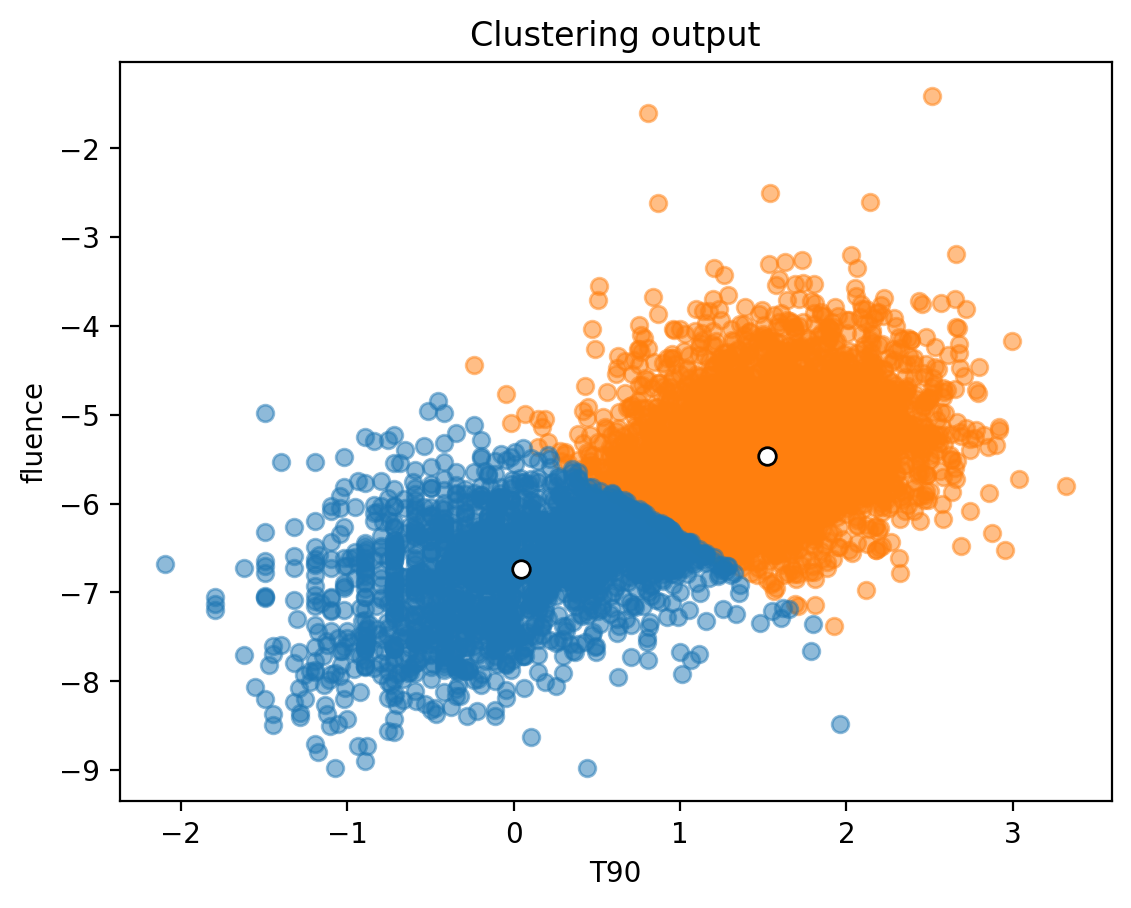

In [37]:
clf = KMeans(n_clusters=2) #Try 2 clusters to start with, but the number of clusters is an hyperparameter
clf.fit(X)
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(X) #labels for each of the points

# plot the data color-coded by cluster id
colors = ['C1', 'C0', 'C2']
for ii in range(3):
    plt.scatter(X[labels==ii,0], X[labels==ii,1], 
                color=colors[ii],alpha=0.5)

plt.scatter(centers[:, 0], centers[:, 1],
           s=40, c='w', edgecolors='k')

plt.xlabel("T90")
plt.ylabel("fluence")
plt.title('Clustering output');

## Mean-shift

In [41]:
n_clusters = 2
scaler = preprocessing.StandardScaler()
Y = scaler.fit_transform(X)
clf = KMeans(n_clusters, n_init = 'auto')
clf.fit(Y)
centers = clf.cluster_centers_

In [51]:
# Compute the Mean-shift clustering
from sklearn.cluster import MeanShift

#bandwidth = 0.4
bandwidth = estimate_bandwidth(X) # this takes a long time...beware
ms = MeanShift(bandwidth=bandwidth, 
               bin_seeding=True, 
               cluster_all=False)
               
#               seeds = centers)
ms.fit(Y)

MeanShift(bandwidth=0.9178233448544739, bin_seeding=True, cluster_all=False)

[-1  0  1  2  3]
0.9178233448544739
number of estimated clusters : 2


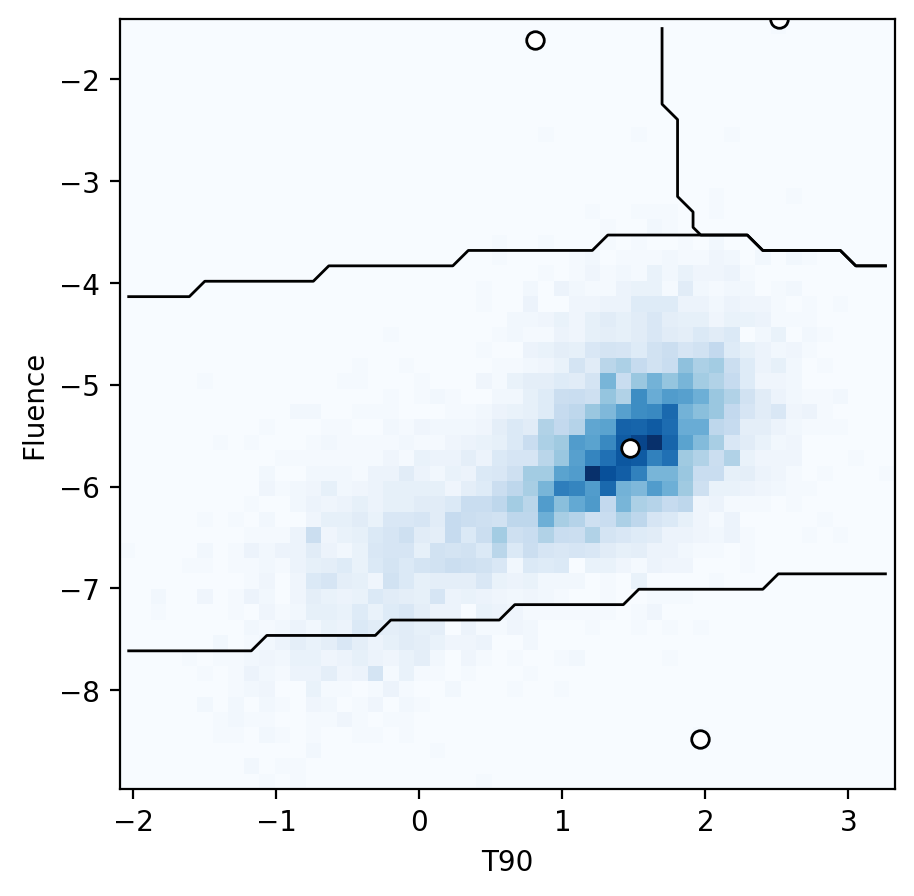

In [52]:
labels_unique = np.unique(ms.labels_)
print(labels_unique)
print(bandwidth)
print("number of estimated clusters :", n_clusters)

# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X[:,0], X[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = scaler.inverse_transform(ms.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel('T90')
ax.set_ylabel('Fluence')

plt.show()

Not worth. Let's set as a seed the centers computed with kmeans

In [57]:
# Compute the Mean-shift clustering
from sklearn.cluster import MeanShift

bandwidth = 0.4
#bandwidth = estimate_bandwidth(X) # With this bandwidth it recognizes only one cluster
ms = MeanShift(bandwidth=bandwidth, 
               bin_seeding=True, 
               cluster_all=False,
               seeds = centers)
ms.fit(Y)

MeanShift(bandwidth=0.4, bin_seeding=True, cluster_all=False,
          seeds=array([[ 0.48590031,  0.42121945],
       [-1.31341074, -1.13857542]]))

[-1  0  1]
0.4
number of estimated clusters : 2


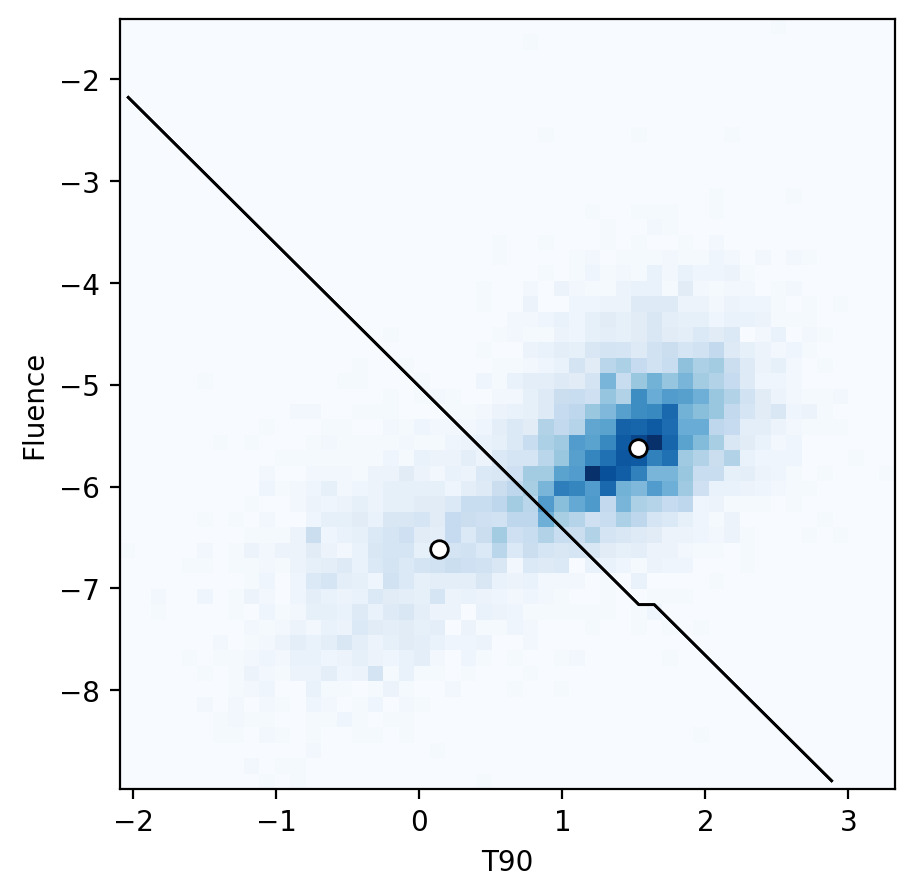

In [58]:
labels_unique = np.unique(ms.labels_)
print(labels_unique)
print(bandwidth)
print("number of estimated clusters :", n_clusters)

# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X[:,0], X[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = scaler.inverse_transform(ms.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel('T90')
ax.set_ylabel('Fluence')

plt.show()